In [ ]:
#To handle the iPhone format, and then convert them to a format OpenCV understands (NumPy arrays).
pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import glob
from PIL import Image
from pillow_heif import register_heif_opener

# 1. Register HEIF opener so PIL can read iPhone photos( Image Compatibility Setup )-  to allow PIL to decode high-efficiency iPhone image formats
register_heif_opener()

# 2. Geometry Configuration
# Define the internal corner dimensions of the chessboard (columns - 1, rows - 1)
GRID_SIZE = (9, 6)

# Initialize "Object Points" which represent the 3D coordinates (X, Y, Z)
# of the corners in a local coordinate system (assuming Z=0 for a flat plane)
objp = np.zeros((GRID_SIZE[0] * GRID_SIZE[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:GRID_SIZE[0], 0:GRID_SIZE[1]].T.reshape(-1, 2)

# Lists to store the mapped coordinates from all successful images
objpoints = []
imgpoints = []

# 3. Data Acquisition
# Use glob to retrieve the file paths of all calibration images in the directory
images = glob.glob('/content/drive/MyDrive/Balapavani_Calibration/*.HEIC')

print(f"Found {len(images)} images. Starting processing...")

for fname in images:
    # Read HEIC using PIL and convert to OpenCV format
    heic_file = Image.open(fname)
    img = cv2.cvtColor(np.array(heic_file), cv2.COLOR_RGB2BGR)
# Convert image to grayscale to simplify corner detection math
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Use the OpenCV chessboard detection algorithm to find internal grid intersections
    ret, corners = cv2.findChessboardCorners(gray, GRID_SIZE, None)
# If the grid is successfully localized in the image
    if ret:
        objpoints.append(objp)

        # Apply sub-pixel refinement to the corner locations for higher mathematical precision
        # This is critical for accurate focal length estimation in Step 2

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)
        print(f"Successfully processed: {fname}")
    else:
        print(f"Corners NOT found in: {fname} - check lighting or grid size.")


# 4. Mathematical Calibration
# Check if enough image samples were collected to solve the system of equations
if len(objpoints) > 0:
  # Calibrate the camera to solve for the Intrinsic Matrix (mtx) and Distortion Coefficients (dist)
    # This maps the relationship between the 3D world and 2D image plane

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Save parameters to a compressed file for use in the Step 2 measurement script

    np.savez('camera_params.npz', mtx=mtx, dist=dist)
    print("\nCalibration Successful!")
    print("Camera Matrix:\n", mtx)
else:
    print("\nCalibration Failed: No corners were detected in any images.")

Found 17 images. Starting processing...
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0510.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0522.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0526.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0525.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0511.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0518.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0521.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0515.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0520.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0513.HEIC
Successfully processed: /content/drive/MyDrive/Balapavani_Calibration/IMG_0514.HEIC
Successfully processed: /content/dri

In [ ]:
import numpy as np

def get_real_dimension(pixel_size, focal_length, distance_mm):
    """
    Applies the Perspective Projection Equation:
    Real Size = (Pixel Size * Distance) / Focal Length
    This function utilizes the Pinhole Camera Model's similar triangles
    relationship to map 2D image measurements back to 3D world dimensions.
    """
    return (pixel_size * distance_mm) / focal_length

# 1. Intrinsic Parameters (From Step 1 Calibration)
# This is the 'fx' value from the K matrix, representing focal length in pixels.
f_pixel = 4672.08

# 2. Extrinsic/Experimental Constants (From Step 3 Validation)
# The physical distance (Z-axis) from the camera's optical center to the object.
distance_mm = 3048  # 10 feet in millimeters

# 3. Image Feature Extraction
# These coordinates define the vertical span of the object in the image plane.
# Coordinates must be retrieved from the validation image (3.048m distance).
y_top = 1500      # Y-coordinate of the object's highest point
y_bottom = 1850   # Y-coordinate of the object's lowest point

# Calculate the Euclidean distance in pixels along the vertical axis
pixel_height = abs(y_bottom - y_top)


# 4. Dimension Reconstruction
# Only proceed if a valid object has been identified (pixel height > 0)
if pixel_height > 0:
  # Compute the real-world height using the calibrated focal length and measured depth
    real_height = get_real_dimension(pixel_height, f_pixel, distance_mm)
    # Output the result in millimeters for high-precision validation
    print(f"Calculated Real Height: {real_height:.2f} mm")

Calculated Real Height: 228.34 mm


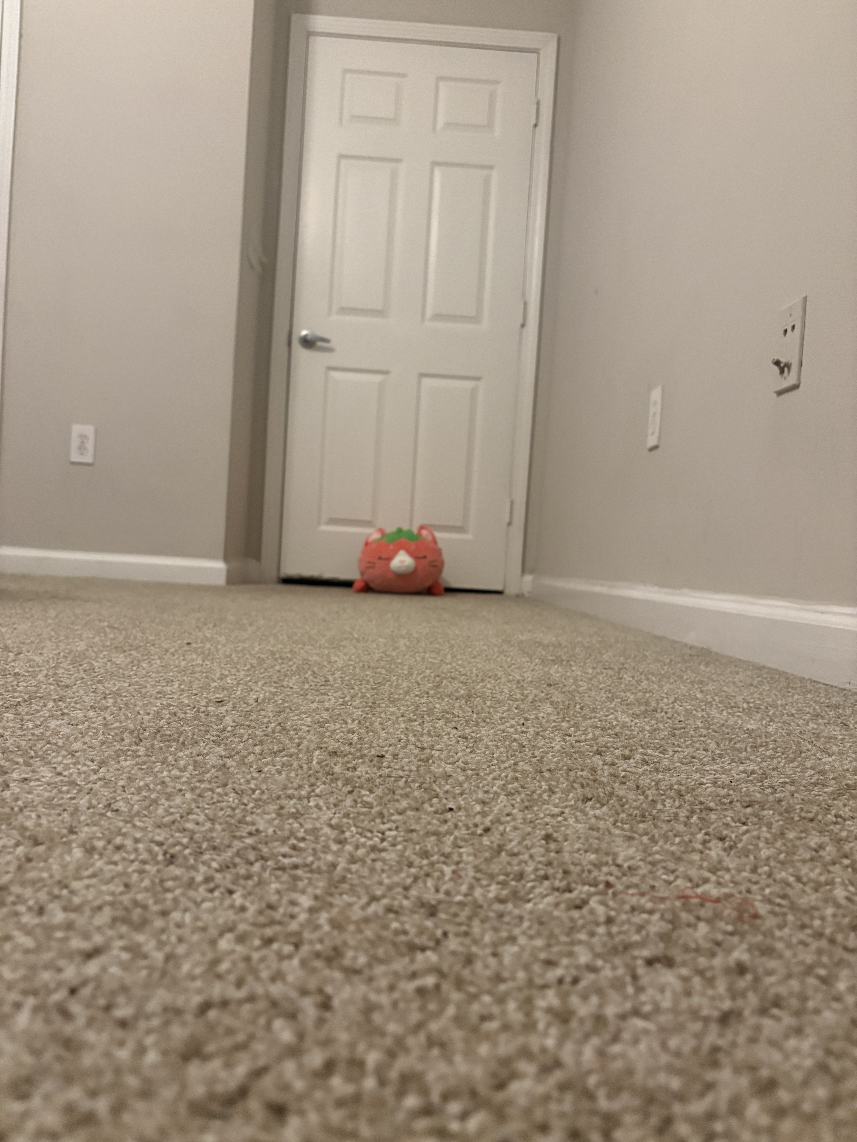

------------------------------
Image used: /content/drive/MyDrive/Balapavani_Calibration/plushie_validation.HEIC
Calculated Real Height: 228.34 mm
------------------------------


In [9]:
import numpy as np
import cv2
from PIL import Image
from pillow_heif import register_heif_opener
from google.colab.patches import cv2_imshow

# 1. Setup for HEIC (iPhone) images
register_heif_opener()

def get_real_dimension(pixel_size, focal_length, distance_mm):
    return (pixel_size * distance_mm) / focal_length

# 2. Parameters from Step 1 and Step 3
f_pixel = 4672.08
distance_mm = 3048

# 3. ADDED PATH: Point to your plushie validation image
# Replace this with your actual file path in Google Drive
img_path = '/content/drive/MyDrive/Balapavani_Calibration/plushie_validation.HEIC'

# Load and show the image to verify the path is correct
heic_file = Image.open(img_path)
img = cv2.cvtColor(np.array(heic_file), cv2.COLOR_RGB2BGR)

# Resize slightly so it fits the screen during your recording
display_img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)
cv2_imshow(display_img)

# 4. Calculation using the pixel coordinates you found
y_top = 1500
y_bottom = 1850
pixel_height = abs(y_bottom - y_top)

if pixel_height > 0:
    real_height = get_real_dimension(pixel_height, f_pixel, distance_mm)
    print("-" * 30)
    print(f"Image used: {img_path}")
    print(f"Calculated Real Height: {real_height:.2f} mm")
    print("-" * 30)